# RANSAC
## A simple explainantion, its limitations and improvements
This is a demo to explain RANSAC algorithm, its limitation and the ways to improve it. The goal of this demo is to give an explanation in most simple terms, so that anyone could read it and only require at most 2-3 google searches.

####The Story
You have a robot with laser range sensor moving inside a room full of obstacles. The sensor detects any obstacle in its view and gives you 2-D polar coordinates of the obstacles.
You can do computation of the raw data and manipulate your robot accordingly. But, you might also want to bring in some planning in your robot or construct a map of the room. For instance, you might want to code an algorithm known as ["bug2"](http://www.cs.cmu.edu/~motionplanning/lecture/Chap2-Bug-Alg_howie.pdf) in which your robot imitates a bug to reach a goal. This algorithm involves a "wall following" in which your robot moves "parallel" to the wall boundaries. 
This task is made simpler if you think of walls as a bunch of lines. The slope of these wall boundary lines can be computed and your robot can be controlled to move in the direction of the "slope".
This nicely brings us to the topic this notebook explains.
####Problem Statement
The problem statement is fitting a line on bunch of data 2-D points (but can be n-dimensional) in space.
####RANSAC Algorithm
There are many resources regarding RANSAC you can find on the web. The algorithm is easy to understand and implement, and is also computationaly efficient. The limitation is its assumption, that the data points should look like a line to begin with! There should be sufficient number inliers in the data that represents a single line. You will soon find out why. We will also discuss how to handle multiple lines in the data.


In [2]:
# Importing necessary libraries
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

## Generate line points and add gaussian noise
Here I generate a dummy data to run RANSAC on. I generate x and y using a random line equation. Then I add some random noise to it. In the below plot, you see the generated data.

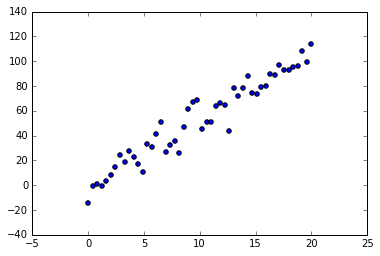

In [5]:
# n = number of points
n = 50
x = np.linspace(0,20,num=n)

# equation of line y = mx + c
y = 5*x + 2

# add gaussian noise
noise = np.random.normal(loc = 0.0, scale=10.0, size=n)
y += noise
plt.scatter(x,y)

##Some useful functions
These are just some useful funcitons that I will need later. The names and comments are self-explainatory.

In [6]:
# line_func = represents two-point line equation. This is used to generate points on a line
def line_func(pt_x,pt_y,x):
    [x1,x2] = pt_x
    [y1,y2] = pt_y
    return ((y2-y1)/(x2 - x1))*(x -x1) + y1

# distance_from_line = to calculate distance of a point from the line
def distance_from_line(pt_x,pt_y,x,y):
    [x1,x2] = pt_x
    [y1,y2] = pt_y
    dist = np.abs((y2 - y1)*x - (x2 - x1)*y + x2*y1 - x1*y2)/np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist


## Ransac Implementation
OK, so this is the algorithm:
    1. You choose two random points from the data and draw a line.
    2. Compute distance of all the other points to this line and categorize them as "inliers" or "outliers". 
        Inliers are those point which are close to the line. Similarly, the outliers. 
        "Closeness" is defined by a threshold value that you need to set based on your judgement about the data.
    3. Repeat the process "k" number of times and select the "best" line out of the "k" lines you have seen. 
        "Best" corresponds to the maximum number of "inliers".

Below is the result you get after 50 iterations (i.e. k = 50).

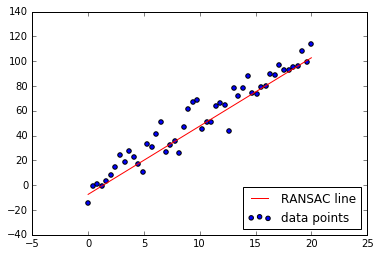

In [10]:
def _ransac(x, y, ransac_iter, inlier_dist_thresh):    
    n = x.size
    max_count_inlier = 0
    line_x = x[0:2]
    line_y = y[0:2]
    inlier_res = np.array([0,1])
    for k in range(ransac_iter):
        ind = np.random.uniform(0,n,size=2)
        ind = np.floor(ind).astype('int')
        if (ind[0] == ind[1]):
            continue
        pt_x = x[ind]
        pt_y = y[ind]
        outlier = np.array([])
        inlier = np.array([])
        for i in range(n):
            if (distance_from_line(pt_x,pt_y,x[i],y[i]) < inlier_dist_thresh):
                inlier = np.append(inlier,i)
            else :
                outlier = np.append(outlier,i)    
        if (inlier.size > max_count_inlier):
            line_x = pt_x
            line_y = pt_y
            max_count_inlier = inlier.size
            inlier_res = inlier
    return line_x, line_y, inlier_res


inlier_dist_thresh = 0.5
ransac_iter = 50
line_x, line_y, inlier_res = _ransac(x,y,ransac_iter,inlier_dist_thresh)
plot_x = np.array([0,20])
plot_y = line_func(line_x,line_y,plot_x)
plt.close()
plt.scatter(x,y,label='data points')
plt.plot(plot_x,plot_y,c='r',label='RANSAC line')
plt.legend(loc = 4)
plt.show()

##Why does it work
Consider this. You are hungry and you have a bag of apples. Some of them are rotten and some of them are not. You cannot look inside the bag and can only choose one at a time. This is what most people would do:
    1. Choose an apple
    2. Look at it, smell it. If its bad, throw it away, if its good but you think you can do better,
        keep it aside and keep on looking
    3. Depending on how pedantic one is, one might stop early or repeat 1,2,3 till the bag is empty
 Now, there is one more factor other than the degree of pedantness that governs the number of iterations in the above algorithm. That is, the number of rotten apples in the bag, and the total number of apples in the bag. If it was filled with rotten ones, it would be quite long before you will find something eatable. The numbers affect the chances.

What RANSAC says is that you assume the bag was full of good apples (inliers). It says you to take out these apples only k number of times, each time replacing with a good one. In the end when you are with your best option, no matter how rotten or fresh the best one is, eat it. 

Now, you can easily transform your algorithm from apples to lines and data points. There is actually one-one mapping between this and the previously stated algorithn, with a slight differnce on the second point. For judging a line, you have to compare with all the other data points in the "bag". 

Similarly, this concept can be extrapolated to any general model. The key would be the "point 2", something to judge your "fitted-model" (in our case, a line) on some basis of some objective or loss function (in our case, distance of all other points from the line) 

##Limitations
You can easily see the limitations of the above algorithm. First, is that you have to assume to the linearity of the data, that most of it is inliers and only some are outliers. Second, are the parameters which you have to decide on - number of iterations, k, and the threshhold distance that defines the inlier or an outlier.

##RANSAC on Non-linear data
This is what RANSAC will come up with on a non-linear data.

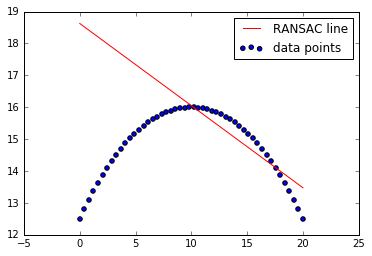

In [11]:
y = np.sqrt(np.abs(256 - (x - 10)**2))
inlier_dist_thresh = 0.5
ransac_iter = 50
line_x, line_y, inlie_res = _ransac(x,y,ransac_iter,inlier_dist_thresh)

plot_x = np.array([0,20])
plot_y = line_func(line_x,line_y,plot_x)
plt.close()
plt.scatter(x,y,label='data points')
plt.plot(plot_x,plot_y,c='r',label='RANSAC line')
plt.legend()
plt.show()

##Improved RANSAC
TODO Need - robotics - multiple lines

TODO Explaination

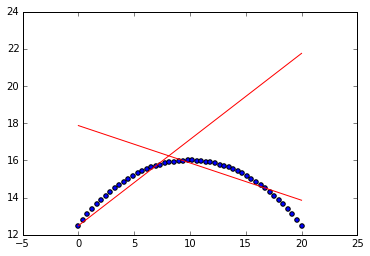

In [156]:
def multiple_ransac(x,y,ransac_iter,inlier_dist_thresh,acceptable_ratio):
    list_line_x = np.array([[]])
    list_line_y = np.array([[]])
    while (True):
        line_x, line_y, inlier_res = _ransac(x,y,ransac_iter,inlier_dist_thresh)
        x = np.delete(x, inlier_res)
        y = np.delete(y, inlier_res)
        if (x.size == 0 or inlier_res.size < acceptable_ratio*x.size):
            break
            
        if (list_line_x.size == 0) :
            list_line_x = np.array([line_x])
            list_line_y = np.array([line_y])
        else :
            list_line_x = np.vstack((list_line_x,line_x))
            list_line_y = np.vstack((list_line_y,line_y))
    return list_line_x,list_line_y

y = np.sqrt(np.abs(256 - (x - 10)**2))
inlier_dist_thresh = 0.5
ransac_iter = 50
acceptable_ratio = 0.33
list_line_x,list_line_y = multiple_ransac(x,y,ransac_iter,inlier_dist_thresh,acceptable_ratio)

plt.close()
plt.scatter(x,y)
plot_x = np.array([0,20])
for i in range(list_line_x.shape[0]):
    plot_y = line_func(list_line_x[i,:],list_line_y[i,:],plot_x)
    plt.plot(plot_x,plot_y,c='r',label='line')
plt.show()


## Multiline RANSAC on a more curvy data

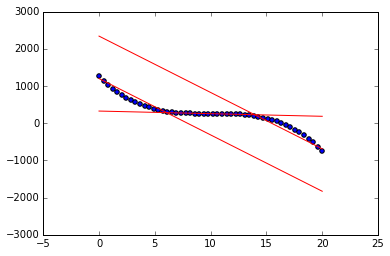

In [172]:
y = 256 - (x - 10)**3
inlier_dist_thresh = 1
ransac_iter = 50
acceptable_ratio = 0.33
list_line_x,list_line_y = multiple_ransac(x,y,ransac_iter,inlier_dist_thresh,acceptable_ratio)

plt.close()
plt.scatter(x,y)
plot_x = np.array([0,20])
for i in range(list_line_x.shape[0]):
    plot_y = line_func(list_line_x[i,:],list_line_y[i,:],plot_x)
    plt.plot(plot_x,plot_y,c='r',label='line')
plt.show()

##Limitation of Multiple-Line RANSAC
TODO the parameters
